In [0]:
!git clone https://github.com/rilindmehmeti/track-data.git

In [0]:
!ls track-data

In [0]:
!pip3 install imgaug

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [0]:
data_directory = 'track-data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(data_directory, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', -1)
data.head()

In [0]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data.head()

In [0]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


In [0]:
print('total_data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
           
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
  
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [0]:
print(data.iloc[1])
def load_img_steering(data_directory, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, lef, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(data_directory, center.strip()))
    steering.append(float(indexed_data[3]))
    
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(data_directory+'/IMG', data)

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)

print('Training Samples: {} \nValid Samples: {}'.format(len(X_train), len(X_valid)))

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')

axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [0]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

In [0]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image


In [0]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

In [0]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

In [0]:
ncol = 2
nrow = 10

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths)-1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
  
  original_image = mpimg.imread(random_image)
  augumented_image, steering = random_augment(random_image, random_steering)
  axes[i][0].imshow(original_image)
  axes[i][0].set_title('Original Image - Steering Angle:' + str(random_steering) )

  axes[i][1].imshow(augumented_image)
  axes[i][1].set_title('Modified Image - Steering Angle:' + str(steering))

In [0]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

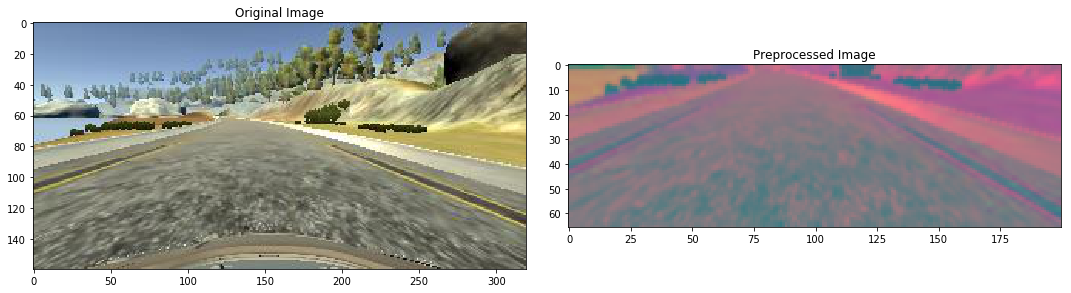

In [0]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')



In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering)) 

In [0]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

Text(0.5, 1.0, 'Validation Image')

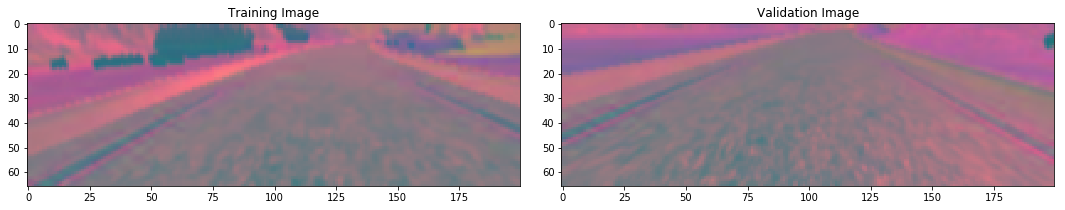

In [0]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [0]:
def model(activation_function, learning_rate, loss_function):  
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation=activation_function))
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation=activation_function))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation=activation_function))
  model.add(Convolution2D(64, 3, 3, activation=activation_function))
  model.add(Convolution2D(64, 3, 3, activation=activation_function))
  #model.add(Dropout(0.5))
  
  model.add(Flatten())
  
  model.add(Dense(100, activation=activation_function))
  #model.add(Dropout(0.5))
  
  model.add(Dense(50, activation=activation_function))
  #model.add(Dropout(0.5))
  
  model.add(Dense(10, activation=activation_function))
  #model.add(Dropout(0.5))
  
  model.add(Dense(1))
 
  optimizer = Adam(lr=learning_rate)
  model.compile(loss=loss_function, optimizer=optimizer)
  return model

In [0]:
model = model('elu', 0.0001, 'mse')
print(model.summary())

In [0]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Text(0.5, 0, 'Epoch')

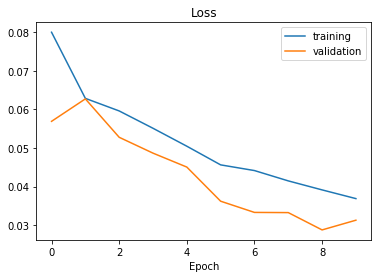

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
#files.download('model.h5')